# Chapter 7
## Moving Beyond Linearity

Relaxing the linearity assumption while still maintaining as much interpretibility as possible.

__1. Polynomial Regression__ :- Extends the linear model by adding extra predictors, obtained by raising each of the original predictors to a power.


__2. Step Functions__ :- Cut the range of a variable into K distinct regions in order to produce a qualitative variable. This has the effect of fitting a piecewise constant function.


__3. Regression Splines__ :- Dividing a variable to K distinct regions. Within each region, a polynomial is fit to data. The polynomial join smoothly at region boundaries called knots. 


__4. Smoothing Splines__ :- They result from minimizing a RSS criterion subject to smoothness penalty.


__5. Local Regression__ :- Similar to splines but the region are allowed to overlap.


__6. Generalized Additive Models__ :- Extend the above method to deal with multiple predictors.

### Polynomial Regression 
A polynomial regression model can be written as 
$$y_i = \beta_0 + \beta_1 x_{i} +  \beta_2 x_{i}^{2} +....+ \beta_d x_{i}^{d} + \epsilon_i$$
$\epsilon_i$ = error term.

large value of d means more flexible curve especially near the boundary of X. hence it is unusual to use d greater than 3 or 4. 

The coefficients can be estimated using least squares. Least squares returns varaince estimates for each fitted coefficients $\hat \beta_j$

If $l_o$ is the point estimate = $(1,x_0,x_{0}^{2},..)$ and C is the covaraince matrix then pointwise standard error can be written as $l_{0}^{T}Cl_0$.
This can be used to estimate the CI.


In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error
from patsy import dmatrix

In [2]:
# Readin wage data in our environment.
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Wage.csv"
Wage = pd.read_csv(url, index_col = 0, error_bad_lines = False)
Wage["Wage_250"] = 0
Wage.loc[Wage.wage > 250, "Wage_250"] = 1 # Creating binary variable for logistic model

In [114]:
X = np.array(Wage["age"]).reshape(-1,1)
y = np.array(Wage["wage"])
polynomial_features= PolynomialFeatures(degree=4)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y,xp).fit() # Fitting a linear model with polynomial terms

y = np.array(Wage["Wage_250"])
logit_model = sm.Logit(y,xp).fit() # Fitting a logistic regression model with polynomial terms


Optimization terminated successfully.
         Current function value: 0.116870
         Iterations 12


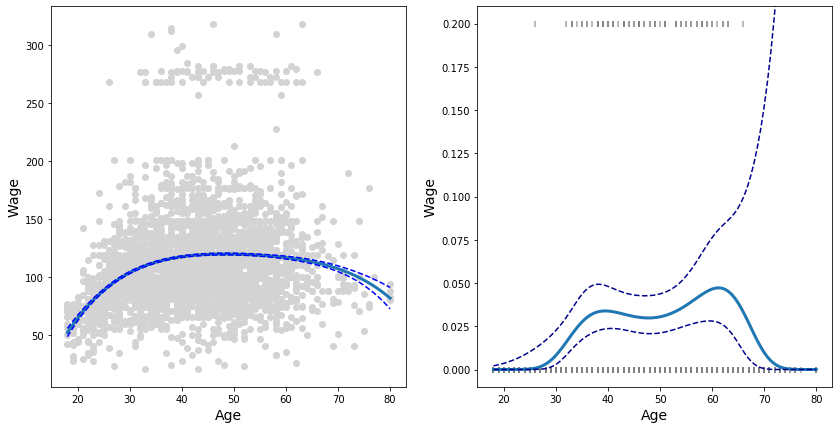

In [115]:
age_lin = np.linspace(min(Wage.age), max(Wage.age), 100)
age_poly = polynomial_features.fit_transform(age_lin.reshape(-1,1))

prediction = model.get_prediction(age_poly) # Getting the prediction interval for the linear model
CI = prediction.summary_frame(alpha = 0.5)

fig = plt.figure(figsize = (14,7))
ax1 = fig.add_subplot(121)
ax1.scatter(Wage.age, Wage.wage, color = "lightgrey")
ax1.plot(age_lin, model.predict(age_poly), linewidth = 3.0)
ax1.plot(age_lin, CI.mean_ci_lower, linestyle = "--", color = "blue")
ax1.plot(age_lin, CI.mean_ci_upper, linestyle = "--", color = "blue")
ax1.set_xlabel("Age", fontsize = 14)
ax1.set_ylabel("Wage", fontsize = 14)

# Prediction interval for the logistic regression model.
l0 = np.dot(age_poly,logit_model.params)
std_error = np.array([np.sqrt(np.dot(np.dot(g,logit_model.cov_params()),g)) for g in age_poly])
upper = l0 + 2 * std_error
lower = l0 - 2 * std_error
upper = np.exp(upper)/(1 + np.exp(upper))
lower = np.exp(lower)/(1 + np.exp(lower))

ax2 = fig.add_subplot(122)
ax2.scatter(Wage.age, Wage.Wage_250/5, color = "grey", marker = "|", alpha = 0.7)
ax2.plot(age_lin, logit_model.predict(age_poly), linewidth = 3.0)
ax2.plot(age_lin, lower, linestyle = "--", color = "darkblue")
ax2.plot(age_lin, upper, linestyle = "--", color = "darkblue")
ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel("Age", fontsize = 14)
ax2.set_ylabel("Wage", fontsize = 14)
plt.show()

The above plot shows how the prediction interval becomes wider at the edge of X variable. This happens because the at the extremes there are usually less observations and hence high variance in the estimates also the polynomial regression impose a global structure on the function of X so we can't control the shape where there is less no. of data.

### Step Functions
Step function breaks X into bins and fit a different constant in each bin. This amounts to converting a continous variable into ordered categorical variable. 

We create cut points $c_1,c_2, ... ,c_k$ in range of X, then construct K+1 new variables.
$$C_0(X) = I(X<c_1)$$
$$C_1(X) = I(c_1\le X\le c_2)$$
$$C_2(X) = I(c_2\le X\le c_3)$$
$$.....$$
$$C_{k-1}(X) = I(c_{k-1}\le X\le c_k)$$
$$C_k(X) = I(X \ge c_k)$$
Where I(.) = indicator function.

Finally, the linear equation can be written as 
$$y_i = \beta_0 + \beta_1 C_1(x_{i}) +  \beta_2 C_2(x_{i}) +....+ \beta_k C_k(x_{i}) + \epsilon_i$$

For X < $c_1$, all the predictors are zero so $\beta_0$ can be interpreted as mean value of Y for X < $c_1$.
$$y_i = \beta_0 + \beta_j\ \ \ for\ \ \ c_j \le X \le c_{j+1}$$
$\beta_j$ = average increase in response for X in $c_j \le X \le c_{j+1}$ relative to $X < c_1$

A similar logistic model would be 
$$P(y_i>c|x_i) = \frac{exp(\beta_0 + \beta_1 C_1(x_{i}) +  \beta_2 C_2(x_{i}) +....+ \beta_k C_k(x_{i}))}{1 + exp(\beta_0 + \beta_1 C_1(x_{i}) +  \beta_2 C_2(x_{i}) +....+ \beta_k C_k(x_{i}))}$$

However, selecting bins can be challenging unless there are natural breakpoints in predictors.

In [116]:
# Creating new variable with cut points at 30,50 and 65.
Wage["Age_30_50"] = 0
Wage.loc[(Wage.age > 30) & (Wage.age < 50), "Age_30_50"] = 1
Wage["Age_50_65"] = 0
Wage.loc[(Wage.age >= 50) & (Wage.age < 65), "Age_50_65"] = 1
Wage["Age_ge_65"] = 0
Wage.loc[Wage.age >= 65, "Age_ge_65"] = 1
X = np.array(Wage[["Age_30_50","Age_50_65","Age_ge_65"]])
X = sm.add_constant(X)
y = np.array(Wage["wage"])

model = sm.OLS(y,X).fit() # Fitting a linear model with step functions

y = np.array(Wage["Wage_250"])
logit_model = sm.Logit(y,X).fit() # Fitting a logistic regression model with step functions

Optimization terminated successfully.
         Current function value: 0.117675
         Iterations 10


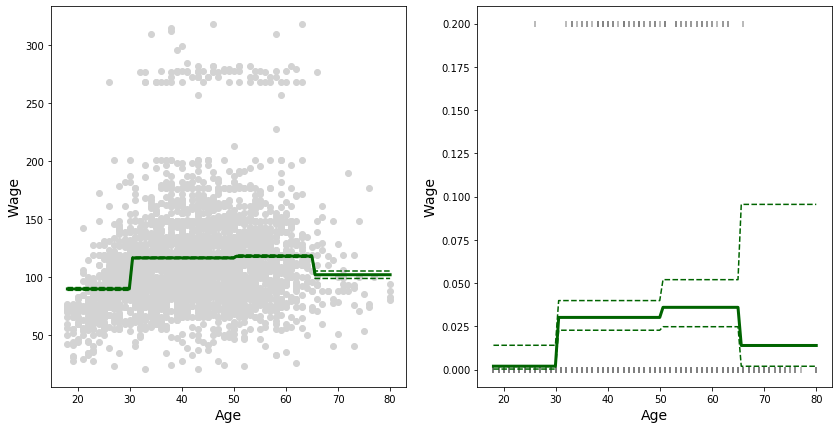

In [124]:
age = np.linspace(min(Wage.age), max(Wage.age), 100)
test_data = pd.DataFrame({"age":age})

test_data["Age_30_50"] = 0                          
test_data.loc[(test_data.age > 30) & (test_data.age < 50), "Age_30_50"] = 1
test_data["Age_50_65"] = 0
test_data.loc[(test_data.age >= 50) & (test_data.age < 65), "Age_50_65"] = 1
test_data["Age_ge_65"] = 0
test_data.loc[test_data.age >= 65, "Age_ge_65"] = 1 
test_X = np.array(test_data[["Age_30_50","Age_50_65","Age_ge_65"]])
                          
test_X = sm.add_constant(test_X)

prediction = model.get_prediction(test_X) # Getting the prediction interval for the linear model
CI = prediction.summary_frame(alpha = 0.5)

fig = plt.figure(figsize = (14,7))
ax1 = fig.add_subplot(121)
ax1.scatter(Wage.age, Wage.wage, color = "lightgrey")
ax1.plot(age, model.predict(test_X), linewidth = 3.0, color = "darkgreen")
ax1.plot(age, CI.mean_ci_lower, linestyle = "--", color = "darkgreen")
ax1.plot(age, CI.mean_ci_upper, linestyle = "--", color = "darkgreen")
ax1.set_xlabel("Age", fontsize = 14)
ax1.set_ylabel("Wage", fontsize = 14)

# Prediction interval for the logistic regression model.
l0 = np.dot(test_X,logit_model.params)
std_error = np.array([np.sqrt(np.dot(np.dot(g,logit_model.cov_params()),g)) for g in test_X])
upper = l0 + 2 * std_error
lower = l0 - 2 * std_error
upper = np.exp(upper)/(1 + np.exp(upper))
lower = np.exp(lower)/(1 + np.exp(lower))

ax2 = fig.add_subplot(122)
ax2.scatter(Wage.age, Wage.Wage_250/5, color = "grey", marker = "|", alpha = 0.7)
ax2.plot(age, logit_model.predict(test_X), linewidth = 3.0, color = "darkgreen")
ax2.plot(age, lower, linestyle = "--", color = "darkgreen")
ax2.plot(age, upper, linestyle = "--", color = "darkgreen")
ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel("Age", fontsize = 14)
ax2.set_ylabel("Wage", fontsize = 14)
plt.show()

We can see that between the cutpoints the prediction curve is flat. This is called __piecewise-constant regression__ model.

### Basis Functions
Instead of using X, use a function of X b(X) as input in the model. Polynomial and piecewise-constant regression is a special case of basis function.
$$y_i = \beta_0 + \beta_1 b_1(x_{i}) +  \beta_2 b_2(x_{i}) +....+ \beta_k b_k(x_{i}) + \epsilon_i$$

Basis function are fixed and known. We can use least squares to estimate them and hence all the inference tool for linear models can be applied.

### Regression Splines

__1. Piecewise Polynomial__ :-
It involves fitting seperate low degree polynomials. For eg. a polynomial equation can be written as
$$y_i = \beta_0 + \beta_1 x_i + .... + \beta_nx_i^2 + \epsilon_i$$

In piecewise regression $\beta's$ will change in different regions of X. The point where coefficients changes are called knots.

$$y_i = \beta_{01} + \beta_{11} x_i + .... + \beta_{n1} x_i^n + \epsilon_i , x_i < c$$
$$y_i = \beta_{02} + \beta_{12} x_i + .... + \beta_{n2} x_i^n + \epsilon_i , x_i \ge c$$
* We are fitting 2 different polynomials for 2 different regions of X each can be fitted using least squares.
* More knots means more flexible piecewise polynomial. 
* K knots means we are fitting K+1 functions.

__2. Constraints and Splines__ :-
A piecewise polynomial can look ridiculous because the curve won't be smooth at the knots and could take a weird shape. To solve this, we use some constraints to make it continous. 

Each constraint is going to free one degree of freedom. 

* A piecewise polynomial with constraints about continuity in derivative upto degree d-1 at each knot is a __degree d spline__.

__3. The Spline Basis Representation__ :-
To fit a model with piecewise regression under the constraints that it be continous? We can use a basis model to represent such model.

For e.g. A cubic spline with k knots
$$y_i = \beta_0 + \beta_1 b_1(x_i) + \beta_2 b_2(x_i) + .... + \beta_{K+3}b_{K+3}(x_i) + \epsilon_i$$
for an appropriate choice of basis function $b_1, b_2, ... , b_{K+3}$. 

The idea is to start with a basis for a cubic polynomial $(x,\ x^2,\ x^3)$ and then add one truncated power basis function per knot. 

$$h(x,\eta) = (x - \eta)_{+}^{3} = (x - \eta)^{3}\ if\ x > \eta,\ 0\ \ otherwise$$ 
where $\eta$ is the knot.

Adding a term of the form $\beta_4h(x,\eta)$ to the model for a cubic polynomial will lead to a discontinuity in only third derivative at $\eta$ and the function will remain continous at first and second derivative at each knots.

In total we have an intercept and 3 + K predictors.

One drawback of the splines is that it can have very high variance at the outer range of the predictors.

A __natural spline__ is a regression spline with additional boundary constraints, the function needs to be linear at the boundary.

This additional constraint means the natural splines generally produce more stable estimates at the boundaries.

In [71]:
# Cubic Spline
# Defining the X matrix for Cubic Spline
X_spline = dmatrix("bs(Wage.age, knots = (25,40,60), degree = 3, include_intercept = False)",
                   {"Wage.age":Wage.age}, return_type = "dataframe")
model_CS = sm.GLM(Wage.wage, X_spline).fit()

# Natural Spline 
# Defining the X matrix for Natural Spline
X_Nspline = dmatrix("cr(Wage.age, df = 6)",
                   {"Wage.age":Wage.age}, return_type = "dataframe")
model_NS = sm.GLM(Wage.wage, X_Nspline).fit()

age_lin = np.linspace(min(Wage.age), max(Wage.age), 100)

# Prediction for Cubic Spline
predict_CS = model_CS.predict(dmatrix("bs(age_lin, knots = (25,40,60), degree = 3, include_intercept = False)",
                   {"age_lin":age_lin}, return_type = "dataframe"))
prediction_CS = model_CS.get_prediction(dmatrix("bs(age_lin, knots = (25,40,60), degree = 3, include_intercept = False)",
                   {"age_lin":age_lin}, return_type = "dataframe"))

# Prediction for Natural Spline
predict_NS = model_NS.predict(dmatrix("cr(age_lin, df = 6)",
                   {"age_lin":age_lin}, return_type = "dataframe"))
prediction_NS = model_NS.get_prediction(dmatrix("cr(age_lin, df = 6)",
                   {"age_lin":age_lin}, return_type = "dataframe"))

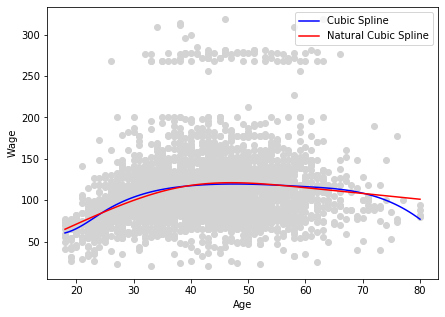

In [91]:
plt.figure(figsize = (7,5))
plt.scatter(Wage.age, Wage.wage, color = "lightgrey")
plt.plot(age_lin, predict_CS, color = "b", label = "Cubic Spline")
plt.plot(age_lin, predict_NS, color = "r", label = "Natural Cubic Spline")
plt.xlabel("Age")
plt.ylabel("Wage")
plt.legend()
plt.show()

__4. Choosing the number and location of knots__ :- 
* Regression spline is more flexible where we have more knots. So we can place more knots in the region where we feell the function might vary most rapidly.
* In practice, knots are placed uniformly usually by quantile of data.
* To understand how many knots are required, one option is to try out different numbers of knots and see what produce the best curve using cross validation.

In [117]:
# Defining the X matrix for Natural Spline
X_Nspline = dmatrix("cr(Wage.age, df = 5)",
                   {"Wage.age":Wage.age}, return_type = "dataframe")

#Linear Regression
model_NS = sm.GLM(Wage.wage, X_Nspline).fit()

predict_NS = model_NS.predict(dmatrix("cr(age_lin, df = 5)",
                   {"age_lin":age_lin}, return_type = "dataframe"))
prediction_NS = model_NS.get_prediction(dmatrix("cr(age_lin, df = 5)",
                   {"age_lin":age_lin}, return_type = "dataframe"))
CI = prediction_NS.summary_frame(alpha = 0.05)

# Logistic Regression
logit_NS = sm.Logit(Wage.Wage_250, X_Nspline).fit()

logit_predict_NS = logit_NS.predict(dmatrix("cr(age_lin, df = 5)",
                   {"age_lin":age_lin}, return_type = "dataframe"))

test_X = np.array(dmatrix("cr(age_lin, df = 5)",
                   {"age_lin":age_lin}, return_type = "dataframe"))

l0 = np.dot(test_X,logit_NS.params)
std_error = np.array([np.sqrt(np.dot(np.dot(g,logit_NS.cov_params()),g)) for g in test_X])
upper = l0 + 2 * std_error
lower = l0 - 2 * std_error
upper = np.exp(upper)/(1 + np.exp(upper))
lower = np.exp(lower)/(1 + np.exp(lower))

Optimization terminated successfully.
         Current function value: 0.116745
         Iterations 11


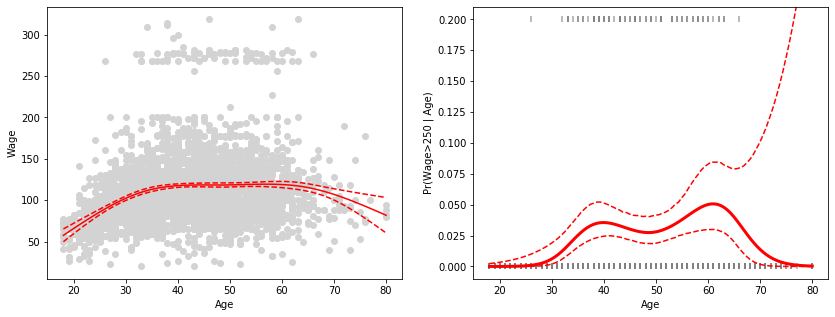

In [127]:
fig = plt.figure(figsize = (14,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(Wage.age, Wage.wage, color = "lightgrey")
ax1.plot(age_lin, predict_NS, color = "r")
ax1.plot(age_lin, CI.mean_ci_lower, color = "r", linestyle = "--")
ax1.plot(age_lin, CI.mean_ci_upper, color = "r", linestyle = "--")
ax1.set_xlabel("Age")
ax1.set_ylabel("Wage")

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(Wage.age, Wage.Wage_250/5, color = "grey", marker = "|", alpha = 0.7)
ax2.plot(age_lin, logit_predict_NS, linewidth = 3.0, color = "r")
ax2.plot(age_lin, lower, linestyle = "--", color = "r")
ax2.plot(age_lin, upper, linestyle = "--", color = "r")
ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel("Age")
ax2.set_ylabel("Pr(Wage>250 | Age)")
plt.show()

In [157]:
# Cross Validation for selecting the degrees of freedom.
MSE = []
for i in range(3,11):
    X = dmatrix("".join(["cr(Wage.age, df = ",str(i),")"]), {"Wage.age":Wage.age}, return_type = "dataframe")
    model = sm.GLM(Wage.wage, X).fit()
    MSE.append(mean_squared_error(Wage.wage, model.predict(X)))
print("MSE for Natural Spline")
print(MSE)
MSE = []
for i in range(3,11):
    X = dmatrix("".join(["bs(Wage.age, df = ", str(i),", degree = 3, include_intercept = False)"]),
                   {"Wage.age":Wage.age}, return_type = "dataframe")
    model = sm.GLM(Wage.wage, X).fit()
    MSE.append(mean_squared_error(Wage.wage, model.predict(X)))

print("MSE for Cubic Spline")
print(MSE)

MSE for Natural Spline
[1602.6078706803874, 1594.2434330646443, 1588.8790610734181, 1588.3725823550035, 1588.3006307332348, 1586.0362661952915, 1586.0935151922436, 1586.0511099965604]
MSE for Cubic Spline
[1592.55813365013, 1591.0332369388123, 1588.7901015292784, 1588.7481559342211, 1588.4572604798514, 1587.8549104628328, 1586.83484890014, 1584.669924518538]


In both the cases, it looks like there is no further improvement from degree 3 onwards.

__5. Comparison to Polynomial Regression__ :-
* Splines can perform better than polynomial regression as it can produce flexible curve without using higher degrees of freedom.
* Also, splines gives more flexibility by fitting complex curve in region of X where f changes rapidly by using more knots.
* The extra flexibility at the boundary region of X helps producing better results than polynomial regression.

In [158]:
# Polynomial Regression
X = np.array(Wage["age"]).reshape(-1,1)
y = np.array(Wage["wage"])
polynomial_features= PolynomialFeatures(degree=15)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y,xp).fit() # Fitting a linear model with polynomial terms

# Natural Spline
X_Nspline = dmatrix("cr(Wage.age, df = 5)",
                   {"Wage.age":Wage.age}, return_type = "dataframe")

model_NS = sm.GLM(Wage.wage, X_Nspline).fit()

predict_NS = model_NS.predict(dmatrix("cr(age_lin, df = 5)",
                   {"age_lin":age_lin}, return_type = "dataframe"))

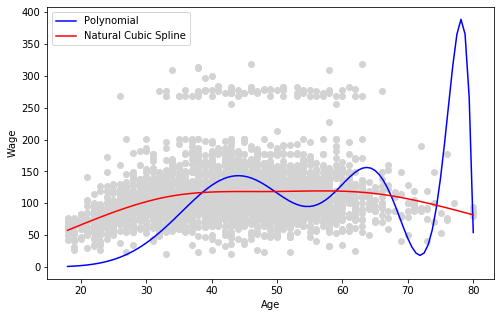

In [166]:
age_poly = polynomial_features.fit_transform(age_lin.reshape(-1,1))
plt.figure(figsize = (8,5))
plt.scatter(Wage.age, Wage.wage, color = "lightgrey")
plt.plot(age_lin, model.predict(age_poly), color = "b", label = "Polynomial")
plt.plot(age_lin, predict_NS, color = "r", label = "Natural Cubic Spline")
plt.xlabel("Age")
plt.ylabel("Wage")
plt.legend()
plt.show()

The above plot shows a polynomial curve with df = 15 and a natural cubic spline. Polynomial is showing a wild behaviour especially near the end.

### Smoothing Splines

In fitting a curve, our objective is to find a function g(x) that fits the observed data well, i.e. we want $RSS = \sum(y_i - g(x_i))^2$ to be small but if we put no constraints on g(x) it interpolates all of $y_i's$ and cause 
overfitting. g( ) should make RSS small and also smooth.

To ensure g is smooth, find g that minimizes 
$$\sum(y_i - g(x_i))^2 + \lambda \int g^{''}(t)^2dt$$
The above formula is "Loss + Penalty".
$\lambda$ - non-negetive tuning parameter. The g( ) that minimizes the function is called smoothing spline.

$\sum(y_i - g(x_i))^2$ = loss function.

$\lambda \int g^{''}(t)^2dt$ = penalty term that penalizes the variability in g.

The notation $g^{''}(t)$ indicates the second derivative (It represent the amount by which the slope is changing). The second derivative is the measure of roughness.

* If it is large in absolute value, g(t) is very wiggly near t and it is close to zero otherwise.
* $\int g^{''}(t)^2dt$ = measure of the total change in the function $g'(t)$ over its entire range.
* If g is grumpy and variable, g'(t) will vary significantly and $\int g^{''}(t)^2dt$ will take large value and vice versa.
* larger the $\lambda$, smoother the g will be.

$\lambda$ = 0, no penalty, g will be grumpy and exactly interpolates training observations.

$\lambda$ = $\infty$, g will be perfectly smooth and it will be a straight line.

For intermediate $\lambda$, g will approximate the training observation but will also be smooth. $\lambda$ controls bias-variance trade off of the smoothing splines.

Properties of g(x) that minimizes the above equation:-
1. It is a piecewise cubic polynomial with knots at uniques values of $x_1, x_2, ... , x_n$ and continous first and second derivative at each knot.
2. It is linear in region outside the extreme knots.
3. It is natural cubic spline.

__Choosing $\lambda$__

As $\lambda$ increase, roughness decrease and the degrees of freedom (no. of free parameters such as no. of coefficients fit in a polynomial and cubic spline) decreases.

A smoothing spline has n parameters and hence n degrees of freedom, these n parameters are heavily constrained or shrunken down, so $\lambda$ controls the roughness and effective degrees of freedom. Hence $df_{\lambda}$(effective degrees of freedom) is a measure of flexibility.

$df_{\lambda}$ increase, flexibility increase, low bias and high variance.

__Calculating effective degrees of freedom__
we can write $$\hat g_{\lambda} = S_{\lambda} y$$
$\hat g$ is the solution of the smoothing spline equation. It is a n-vector contained the fitted values of smoothing spline.

Vectors of fitted value when applying a smoothing spline to the data can be written as nXn matrix $S_{lambda}$ times the response vector y.

Then effective degrees of freedom
$$df_{\lambda} = \sum_{i = 1}^{n}(S_{\lambda})_{ii}$$
the sum of diagonal elements.

* In fitting a smoothing spline, we do not need to select the no. of knots, there will be each knot at each training obs.. We need to choose $\lambda$.
* Cross validation can be used for that purpose.
* LOOCV can be used effectively using 
$$RSS_{CV}(\lambda) = \sum_{i = 1}^{n}(y_i - \hat g_{\lambda}^{(-i)}(x_i))^2 = \sum_{i = 1}^{n}[\frac{y_i - \hat g_{\lambda}(x_i)}{1 - (S_{\lambda})_{ii}}]^2$$
$\hat g_{\lambda}^{(-i)}(x_i)$ indicates the fitted value evaluated at $x_i$.